In [1]:
!pip install -q torch torchvision numpy

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from collections import OrderedDict
import itertools

class Pruner(nn.Module):
    def __init__(self, model, thres = 0.95, function="corrs"):
        super(Pruner, self).__init__()
        self.model = model
        self.to_remove = {}
        self.next_layer = {}
        self.thres = thres
        self.to_train = True #true is train, false is test

        layer_names = list(model.pruning_layers._modules.keys())
        for i, layer_name in enumerate(layer_names):
            layer = model.pruning_layers._modules.get(layer_name)
            if(i < len(model.pruning_layers._modules)-1):
                layer.layer_name = layer_name
                self.next_layer[layer_name] = \
                    model.pruning_layers._modules.get(layer_names[i+1])
                if(function == "corrs"):
                    layer.register_forward_hook(self.correlations)
                elif(function == "l1"):
                    layer.register_forward_hook(self.min_L1)
            i += 1
    
    def prune(self):
        i = 0
        for layer_name, seq_layer in model.pruning_layers._modules.items():
            if(i < len(model.pruning_layers._modules)-1):
                print("remove from ", layer_name, " ", self.to_remove)
                nodes_to_remove = self.to_remove[layer_name]
                n_remove = len(nodes_to_remove)

                layer = seq_layer._modules['0']
                layer.out_channels -= n_remove

                # delete layer_index row in layer, and column in next layer
                np_weights = layer.weight.data.cpu().numpy()
                np_weights = np.delete(np_weights, nodes_to_remove, axis=0)
                layer.weight = Parameter(torch.from_numpy(np_weights).cuda())

                layer_weights = layer.bias.data.cpu().numpy()
                layer_weights = np.delete(layer_weights, nodes_to_remove)
                layer.bias = Parameter(torch.from_numpy(layer_weights).cuda())

                next_layer = self.next_layer[layer_name]._modules['0']
                next_layer.in_channels -= 1
                np_weights = next_layer.weight.data.cpu().numpy()
                np_weights = np.delete(np_weights, nodes_to_remove, axis=1)
                next_layer.weight = Parameter(torch.from_numpy(np_weights).cuda())
                
                batch_layer = seq_layer._modules['3']
                print(batch_layer.running_mean)
                
                running_mean = batch_layer.running_mean.data.cpu().numpy()
                running_mean = np.delete(running_mean, nodes_to_remove)
                batch_layer.running_mean = torch.from_numpy(running_mean).cuda()
                
                batch_weight = batch_layer.weight.data.cpu().numpy()
                batch_weight = np.delete(batch_weight, nodes_to_remove)
                batch_layer.weight = Parameter(torch.from_numpy(batch_weight).cuda())

                batch_bias = batch_layer.bias.data.cpu().numpy()
                batch_bias = np.delete(batch_bias, nodes_to_remove)
                batch_layer.bias = Parameter(torch.from_numpy(batch_bias).cuda())

                running_var = batch_layer.running_var.data.cpu().numpy()
                running_var = np.delete(running_var, nodes_to_remove)
                batch_layer.running_var = torch.from_numpy(running_var).cuda()
                i += 1
    
    
    def forward(self, x):
        #print("shape of x ", x.shape)
        return self.model(x)
    
    def pairs_of_low_correlations(self, layer, input, output):
      if(not self.to_train):
        h, w = output.shape[2], output.shape[3]
        # get correlations
        n_filters = output.shape[1]
        corrs = np.zeros((n_filters, n_filters))
        for i in range(h):
            for j in range(w):
                ap = output[:,:,i,j]
                corrs += np.corrcoef(ap.detach().cpu().numpy().T)
        corrs /= n_filters

        # find filter pairs above correlation threshold
        corrs = np.abs(corrs)
        np.fill_diagonal(corrs, 0)
        sorted_corr = np.sort(corrs.ravel())

        nodes_to_prune = np.where((self.thres <= corrs[:,:]))
        rows, cols = nodes_to_prune[0], nodes_to_prune[1]

        # get filters to remove
        for r in range(0, len(rows)):
            r_i = rows[r]
            if(r_i > -1):
              ind = np.where(cols[r] == rows[:])
              rows[ind] = -1
              ind = np.where(rows[r] == rows[r+1:])
              rows[ind] = -1
        self.to_remove[layer.layer_name] = rows[np.where(rows[:] > -1)]
    
        
    '''
    PRUNING FUNCTIONS
    START HERE
    '''
    def min_L1(self, layer, input, output):
      if(not self.to_train):
        activs = np.abs(input[0].detach().cpu().numpy())
        L1 = np.apply_over_axes(np.sum, activs, [0,2,3])
        L1 = L1.reshape(L1.shape[1])
        self.to_remove[layer.layer_name] = [np.argmin(L1)]

    def correlations(self, layer, input, output):
      if(not self.to_train):
        h, w = output.shape[2], output.shape[3]
        # get correlations
        n_filters = output.shape[1]
        corrs = np.zeros((n_filters, n_filters))
        for i in range(h):
            for j in range(w):
                ap = output[:,:,i,j]
                corrs += np.corrcoef(ap.detach().cpu().numpy().T)
        corrs /= n_filters

        # find filter pairs above correlation threshold
        corrs = np.abs(corrs)
        np.fill_diagonal(corrs, 0)
        sorted_corr = np.sort(corrs.ravel())

        nodes_to_prune = np.where((self.thres <= corrs[:,:]))
        rows, cols = nodes_to_prune[0], nodes_to_prune[1]

        # get filters to remove
        for r in range(0, len(rows)):
            r_i = rows[r]
            if(r_i > -1):
              ind = np.where(cols[r] == rows[:])
              rows[ind] = -1
              ind = np.where(rows[r] == rows[r+1:])
              rows[ind] = -1
        self.to_remove[layer.layer_name] = rows[np.where(rows[:] > -1)]


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pruning_layers = nn.Sequential(OrderedDict([
            ("Layer1",
                nn.Sequential(
                nn.Conv2d(1, 10, 5, padding=2),
                nn.MaxPool2d(2),
                nn.ReLU(), nn.BatchNorm2d(10))),
            ("Layer2",
                nn.Sequential(nn.Conv2d(10, 20, 5, padding=2),
                nn.MaxPool2d(2),
                nn.ReLU(), nn.BatchNorm2d(20))),
            ("Layer3",
                nn.Sequential(nn.Conv2d(20, 20, 5, padding=2),
                nn.MaxPool2d(2),
                nn.ReLU(), nn.BatchNorm2d(20))),
            ("Layer4",
                nn.Sequential(nn.Conv2d(20, 20, 5, padding=2),
                nn.MaxPool2d(2),
                nn.ReLU(), nn.BatchNorm2d(20)))
            ])) 
        self.fc1 = nn.Linear(20, 10)

    def forward(self, x):
        
        x = self.pruning_layers(x)
        x = x.view(-1, 20)
        x = self.fc1(x)
     
        return F.log_softmax(x, dim=1)

model = Net()


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #data.unsqueeze_(0)
            #print("in test size of data ", data.shape)
            output = model(data)
            #print("error")
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return 1. * correct / len(test_loader.dataset)

torch.manual_seed(1)

device = torch.device("cuda")

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, **kwargs)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)#, momentum=0.5)

In [0]:
import time

epoch_range = 3

for epoch in range(epoch_range):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

val_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, **kwargs)

pruning_model = Pruner(model, thres = 0.5, function = "corrs")

pruning_model.to_train = False
t0 = time.time()
acc = test(pruning_model, device, val_loader)
t1 = time.time()
print("testing time", (t1-t0))



Train Epoch: 0 [0/60000 (0%)]	Loss: 2.391955
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.816932
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.348792
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.189932
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.085775
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.118573
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.101945
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.027886
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.069916
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.068591

Test set: Average loss: 0.0559, Accuracy: 9858/10000 (99%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.045614
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.028426
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.103617
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.043557
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.016219
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.021456
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.065139
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.020429
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.022599
T

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in greater_equal



Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99%)

('testing time', 13.14852499961853)


'\nprint("initial model")\nrun_flops(model)\npruning_model = Adder(model, thres = 0.5, function = "var")\nprint("adder model")\nrun_flops(pruning_model)\npruning_model.to_train = False\nt0 = time.time()\nacc = test(pruning_model, device, val_loader)\nt1 = time.time()\nprint("testing time", (t1-t0))\n'

In [0]:
thresholds = np.flip(np.logspace(np.log10(0.7), np.log10(0.98), num=10), axis=0)
sacrifice = 0.01
data = [{} for k in range(len(thresholds)*5)]
print(data)


def run_flops(model, val):
  net = model
  batch = torch.cuda.FloatTensor(64, 1, 28, 28)
  model = add_flops_counting_methods(net)
  model.eval().start_flops_count()
  
  out = model(batch)
  data[val]["flops"] = model.compute_average_flops_cost()
  data[val]["params"] = get_model_parameters_number(model, False)

  print('Output shape: {}'.format(list(out.shape)))
  print('Flops:  {}'.format(flops_to_string(model.compute_average_flops_cost())))
  print('Params: ' + get_model_parameters_number(model))
  return out
  
def get_flop_data(model, val):
  out_shape = out.shape
  

def test_acc(model, val):
  val_loader = torch.utils.data.DataLoader(
      datasets.MNIST('../data', train=False, transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ])),
      batch_size=64, shuffle=True, **kwargs)
  model.to_train = False
  t0 = time.time()
  acc = test(model, device, val_loader)
  t1 = time.time()
  model.to_train = True
  data[val]["final_time"] = t1 - t0
  data[val]["final_acc"] = acc
  print(data)
  print("Inference time ", t1 - t0)
  print("Accuracy", acc)
  return acc

def retrain(model, val):
  epoch_time = []
  epoch_acc = []
  for epoch in range(epoch_range):
      model.to_train = True 
      train(model, device, train_loader, optimizer, epoch)
      model.to_train = False 
      t0 = time.time()
      acc = test(model, device, test_loader)
      t1 = time.time()
      epoch_time.append(t0-t1)
      epoch_acc.append(acc)
      model.to_train = True
  data[val]["epoch_time"] = epoch_time
  data[val]["epoch_acc"] = epoch_acc
  return test_acc(model, val)

def prune_loop(model, thresholds, sacrifice):
  val = 0
  init_model_acc = test_acc(model, val)
  run_flops(model, val)
  #data = {}
  val+=1
  for thres in thresholds:
    print("***** THRES = ", thres, " *****)")
    new_model = Pruner(model, thres = thres, function = "l1")
    data[val]["thres"] =  thres
    run_flops(new_model, val)
    new_model.to_train = False
    acc = test(new_model, device, val_loader)
    new_model.prune()
    new_model.to_train = True
    new_model_acc = retrain(new_model, val)
    
    i = 0
    while(new_model_acc <= init_model_acc - sacrifice and i < 3):
      print("--- accuracy drop ", i, " ---")
      data[val]["thres"] =  thres
      val+=1; 
      new_model_acc = retrain(new_model, val)
      #data[val].append(run_flops(new_model, val))
      run_flops(new_model, val)
      i += 1
    
    if(new_model_acc <= init_model_acc - sacrifice):
      return model
    model = new_model.model
    val+=1
    print(data)
    print("Number of parameters", sum(p.numel() for p in model.parameters()))
  return [model, data]

 
sacrifice = 0.01
new_model = prune_loop(model, thresholds, sacrifice)
print(data)    
  
  

[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in greater_equal



Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99%)

[{'final_time': 13.016390800476074, 'final_acc': 0.9913}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
('Inference time ', 13.016390800476074)
('Accuracy', 0.9913)
Output shape: [64, 10]
Flops:  1.79MMac
Params: 25.0k
('***** THRES = ', 0.98, ' *****)')
Output shape: [64, 10]
Flops:  1.79MMac
Params: 25.0k

Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99%)

('remove from ', 'Layer1', ' ', {'Layer3': [15], 'Layer2': [5], 'Layer1': [0]})
tensor([0.1746, 0.3308, 0.1101, 0.3899, 0.3734, 0.0944, 0.3611, 0.4515, 0.2705,
        0.2490], device='cuda:0')
('remove from ', 'Layer2', ' ', {'Layer3': [15], 'Layer2': [5], 'Layer1': [0]})
tensor([0.5048, 0.3771, 0.5544, 0.5188, 0.4864, 0.2235, 0.5290, 0.4244, 0.5141,
        0.4502, 0.3933, 0.4167, 0.4315, 0.4482, 0.5173, 0.3088, 0

In [0]:
import pickle
f = open("data_125_3epochs_10thres_ACTUAL_l1.pkl", 'w')
pickle.dump(data,f)
f.close()

                                  epoch_acc  \
0                                         0   
1  [0.7656, 0.7596, 0.7614, 0.7633, 0.7628]   
2   [0.7613, 0.7654, 0.7658, 0.7562, 0.764]   
3  [0.7646, 0.7622, 0.7632, 0.7668, 0.7636]   
4  [0.7638, 0.7627, 0.7619, 0.7603, 0.7609]   
5    [0.7631, 0.761, 0.7576, 0.757, 0.7615]   
6   [0.7576, 0.7627, 0.759, 0.7606, 0.7622]   
7   [0.7616, 0.7614, 0.7589, 0.755, 0.7602]   
8  [0.7558, 0.7585, 0.7573, 0.7587, 0.7484]   
9                                         0   

                                          epoch_time  final_acc  final_time  \
0                                                  0     0.7299   11.010538   
1  [-13.0234451294, -13.0402429104, -12.969992876...     0.7628   12.904361   
2  [-12.6817688942, -12.6994400024, -12.668386220...     0.7640   12.635196   
3  [-12.6937990189, -12.5915830135, -12.605195999...     0.7636   12.519230   
4  [-12.4808950424, -12.482281208, -12.4767169952...     0.7609   12.394532   
5  [-12.

'\nfor i in range(0,ran):\n    thr = round(thres[i], 2)\n    if(i > 0 and thr == 0):\n      thr = round(thres[i-1], 2)\n    ax2.annotate(str(thr), (i, flops[i]), textcoords = \'offset points\', xytext = (-5, -15))\n\n#ax1.legend()\n\n\n#params\nplt.figure(1)\nplt.scatter(thres[0:4], params[0:4])\nplt.title("Threshold vs Parameters")\nplt.xlabel("Threshold")\nplt.ylabel("Number of parameters")\n\n#final accuracy\nplt.figure(2)\nplt.scatter(thres[0:4], final_acc[0:4])\nplt.title("Threshold vs Accuracy")\nplt.xlabel("Threshold")\nplt.ylabel("Accuracy")\n\n#final time\nplt.figure(3)\nplt.scatter(thres[0:4], final_time[0:4])\nplt.title("Time (seconds)")\n'

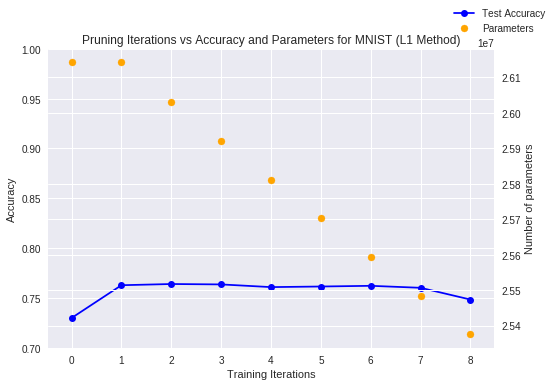

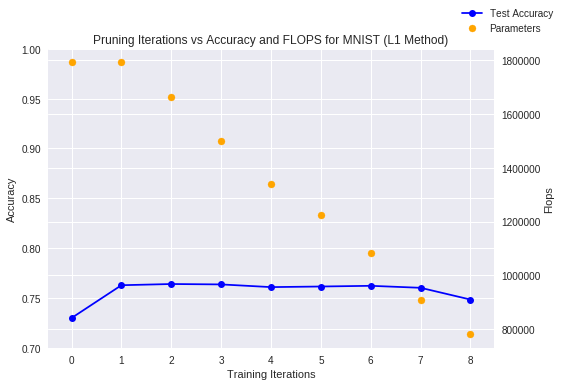

In [0]:
'''
DATA RETRIEVING AND PROCESSING

''' 
import pandas as pd
import pickle 
import matplotlib.pyplot as plt

unpickled_df = pd.read_pickle("data_124_3epochs_5thres_CIFAR_L1.pkl")


final_data = pd.DataFrame(unpickled_df)
final_data = final_data.dropna(how='all')
final_data = final_data.fillna(0, axis = 1)
print(final_data)


params = final_data['params']
thres = final_data['thres']
final_acc = final_data['final_acc']
final_time = final_data['final_time']
flops = final_data['flops']
print(thres.shape)

epoch_acc = np.array(final_data['epoch_acc'][1:5].values.tolist())

plt.figure(0)


fig,ax1 = plt.subplots()

prune_iter = 1
ax2 = ax1.twinx()     
ran = 9
ax1.plot(range(0,ran), final_acc[0:ran], color = "blue", marker = 'o', label = "Test Accuracy")

ax2.scatter(range(0,ran), params[0:ran], color = "orange", label = "Parameters")
plt.title("Pruning Iterations vs Accuracy and Parameters for MNIST (L1 Method)")
ax1.set_xlabel("Training Iterations")
ax1.set_ylim([0.70, 1.0])
ax1.set_ylabel("Accuracy")

ax2.set_ylabel("Number of parameters")
fig.legend()

plt.figure()
fig1,ax1 = plt.subplots()
prune_iter = 1
ax2 = ax1.twinx()
ax1.plot(range(0,ran), final_acc[0:ran], color = "blue", marker = 'o', label = "Test Accuracy")

ax2.scatter(range(0,ran), flops[0:ran], color = "orange", label = "Parameters")
plt.title("Pruning Iterations vs Accuracy and FLOPS for MNIST (L1 Method)")
ax1.set_xlabel("Training Iterations")
ax1.set_ylim([0.70, 1.0])
ax1.set_ylabel("Accuracy")

ax2.set_ylabel("Flops")
fig1.legend()



In [0]:
final_data.to_csv("data_125_3epochs_10thres_cifar_l1.csv")